To consider:
Treat 'Status' and 'Edema' features as ordinal rather than nominal (at least 'Status')?

Rebalance the dataset since we have fewer rows of data where the patient has stage 1 cancer, that is, we have few rows with class variable 1.

Plan for the next coming days:

1. ~~Set up a randomized search grid setup for logistic regression as done for svms. That is, the version without the dataframe~~

2. Assess the bias and variance by using learning curves. Apply it on the optimized models.

3. ~~Perhaps extend the randomized search grids for both lr and svms to be nested to further validate. Then apply learning curves by making a new pipeline with the optimized model.~~

4. Create a function which creates the Kaggle submission, see CA3.

1 - 4 are mandatory.

5. Create new pipelines with other classifiers in the same way as the randomized search grid.

6. __!!! Ehm check if predict is correct because as of now it only predicts class 2 !!!__

# DAT200 CA4 2023

Kaggle username: 

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils import resample

### Reading data

In [2]:
training_data = pd.read_csv(r'data\train.csv')
training_data = training_data.drop('index', axis=1)

### Data exploration and visualisation

Check for missing values

Determine what to do with the missing values, either try to outright remove them or to reverse engineer them accordingly (Ch. 04). Check without outliers vs. engineered value.

In [3]:
training_data.isna().sum()

N_Days            0
Status            0
Drug              0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin         0
Cholesterol      16
Albumin           0
Copper            1
Alk_Phos          0
SGOT              0
Tryglicerides    16
Platelets         4
Prothrombin       0
Stage             0
dtype: int64

In [4]:
# training_data[training_data.isna().any(axis=1)]

Missing values for 'Cholesterol', 'Copper', 'Tryglicerides' and 'Platelets'

In [5]:
# # Pair plot
# plt.figure(figsize=(16, 9))
# sns.pairplot(data=training_data, hue='Stage', palette='Set1')
# # plt.savefig('Pairplot.pdf', dpi=100, format='pdf')
# plt.show()

<ipython-input-6-ef04194d18dc>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = training_data.corr()


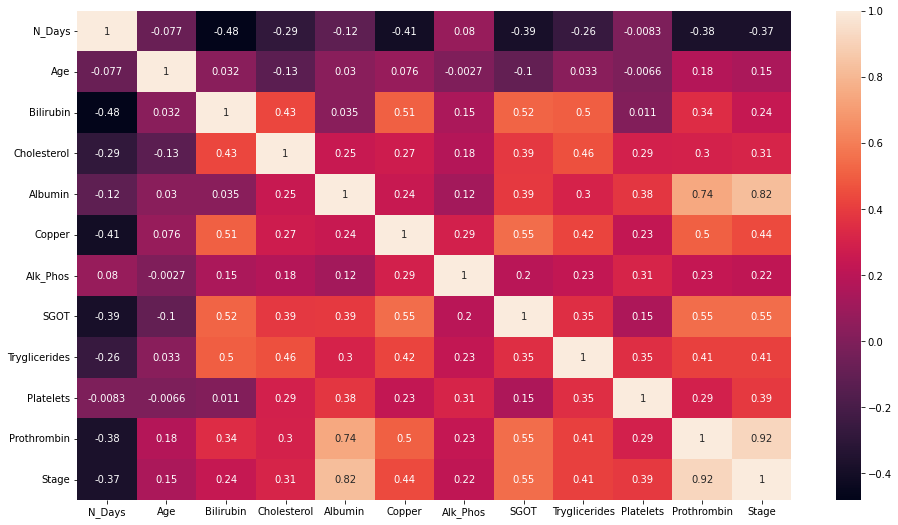

In [6]:
correlation_matrix = training_data.corr()
fig_corr, ax_corr = plt.subplots(figsize=(16, 9))
sns.heatmap(data=correlation_matrix, annot=True, ax=ax_corr)
plt.show()

### Data cleaning

In [7]:
na_df = training_data.isna().sum()
nan_columns = pd.DataFrame(na_df[na_df != 0]).T.columns.tolist()

In [8]:
# Replace nan-values by mean imputation
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(training_data[nan_columns].values)
imputed_values = imr.transform(training_data[nan_columns].values)

In [9]:
imputed_data = training_data.copy()
imputed_data[nan_columns] = imputed_values

or alternatively remove all nan rows rather than inserting imputed values.

In [10]:
# training_data = training_data.dorpna()

### Data exploration after cleaning

In [11]:
# # Pair plot
# plt.figure(figsize=(16, 9))
# sns.pairplot(data=imputed_data, hue='Stage', palette='Set1')
# plt.show()

By looking at 'Albumin' and 'Prothrombin' its easier to linearly seperate the the four classes compared to any other feature, though not perfect.

### Data preprocessing

In [12]:
# Handle nominal categorical features
print(imputed_data.shape)
dummy = pd.get_dummies(imputed_data, drop_first=True)
print(dummy.shape)

(200, 19)
(200, 21)


In [13]:
# plt.figure(figsize=(16, 9))
# sns.pairplot(data=dummy, hue='Stage', palette='Set1')
# plt.show()

In [14]:
dummy['Stage'].value_counts()

3    81
4    70
2    41
1     8
Name: Stage, dtype: int64

In [15]:
upsampled = resample(dummy[dummy['Stage'] == 1],
                     replace=True,
                     n_samples=dummy[dummy['Stage'] == 2].shape[0] - dummy[dummy['Stage'] == 1].shape[0],
                     random_state=134)

In [16]:
upsampled['Stage'].value_counts()

1    33
Name: Stage, dtype: int64

In [17]:
dummy_2 = pd.concat([dummy, upsampled])
dummy_2['Stage'].value_counts()

3    81
4    70
2    41
1    41
Name: Stage, dtype: int64

#### Train test split

In [18]:
X = dummy_2.copy()
X = X.drop('Stage', axis=1)
y = dummy_2['Stage']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=1451842)

#### Scaling

In [20]:
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Modelling

#### Data pipeline with kernel

In [21]:
pipe_svm = make_pipeline(
    StandardScaler(),
    SVC(random_state=13)
    )
# pipe_svm

##### Randomized grid search setup (switch to normal grid search)

In [22]:
# # import warnings
# # warnings.filterwarnings('ignore')

# num_vals = 50
# rng = loguniform(1e-5, 1e3)
# c_range_svm = [10**x for x in range(-5, 5)]
# gamma_range = [10**x for x in range(-2, 4)]
# state = 135

# inner_segments = 10
# outer_segments = 10


# # svc_grid_random = [{'svc__C': rng.rvs(15, random_state=state), 
# #                     'svc__gamma': rng.rvs(15, random_state=state), 
# #                     'svc__kernel': ['linear', 'rbf'],
# #                     'svc__class_weight': [None, 'balanced']}]
              

# svc_grid_random = [{'svc__C': c_range_svm, 
#                     'svc__gamma': gamma_range, 
#                     'svc__kernel': ['linear', 'rbf'],
#                     'svc__class_weight': [None, 'balanced']}]

# n_iter_search = len(c_range_svm) * len(gamma_range)
# random_search_svc = RandomizedSearchCV(estimator=pipe_svm,
#                                        param_distributions=svc_grid_random,
#                                        scoring='accuracy', n_iter=n_iter_search,
#                                        cv=inner_segments, n_jobs=-1)

# scores_nested_svm = cross_val_score(random_search_svc, X_train_std, y_train,
#                                     scoring='accuracy', cv=outer_segments)

# print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_nested_svm),
#                                       np.std(scores_nested_svm)))

# # retrieve best estimator model by using .best_estimator



In [23]:
# import warnings
# warnings.filterwarnings('ignore')

rng = loguniform(1e-5, 1e3)
c_range_svm = [10**x for x in range(-5, 5)]
gamma_range = [10**x for x in range(-2, 4)]
state = 135

inner_segments = 5
outer_segments = 5


# svc_grid_random = [{'svc__C': rng.rvs(15, random_state=state), 
#                     'svc__gamma': rng.rvs(15, random_state=state), 
#                     'svc__kernel': ['linear', 'rbf'],
#                     'svc__class_weight': [None, 'balanced']}]
              

svc_grid_random = [{'svc__C': c_range_svm, 
                    'svc__gamma': gamma_range, 
                    'svc__kernel': ['linear', 'rbf'],
                    'svc__class_weight': [None, 'balanced']}]

n_iter_search = len(c_range_svm) * len(gamma_range)
gs_svc = GridSearchCV(estimator=pipe_svm,
                      param_grid=svc_grid_random,
                      scoring='accuracy', cv=inner_segments, 
                      n_jobs=-1)

scores_nested_svm = cross_val_score(gs_svc, X_train_std, y_train,
                                    scoring='accuracy', cv=outer_segments)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_nested_svm),
                                      np.std(scores_nested_svm)))

# retrieve best estimator model by using .best_estimator



CV accuracy: 0.895 +/- 0.053


In [24]:
gs = gs_svc.fit(X_train_std, y_train)
gs.cv_results_['mean_test_score']
print(gs.cv_results_['mean_test_score'].shape)
print(len(c_range_svm), len(gamma_range))

(240,)
10 6


In [25]:
# scores = gs.cv_results_['mean_test_score'].reshape(len(c_range_svm), len(gamma_range))

# plt.figure(figsize=(8, 6))
# plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
# plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
# plt.xlabel('gamma') # 1/(softness of decision boundary), i.e. small = soft
# plt.ylabel('C')     # 1/(size of support vector margin), i.e. large = tight margin
# plt.colorbar()
# plt.xticks(np.arange(len(gamma_range)), gamma_range)
# plt.yticks(np.arange(len(c_range_svm)), c_range_svm)
# plt.title('Grid Search Accuracy Score')
# plt.show()

In [26]:
rs_svc = gs_svc.fit(X_train_std, y_train)
print(rs_svc.best_params_)
print(rs_svc.score(X_train_std, y_train))
print(rs_svc.score(X_test_std, y_test))

# NB! fit for _std and score for _train_std

{'svc__C': 10, 'svc__class_weight': None, 'svc__gamma': 0.01, 'svc__kernel': 'linear'}
1.0
0.9714285714285714


#### Data pipeline with regularization

In [27]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=19),
                        LogisticRegression(random_state=531, max_iter=500))

pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=19)),
                ('logisticregression',
                 LogisticRegression(max_iter=500, random_state=531))])

In [28]:
# nested cv
num_vals = 50
rng = loguniform(1e-3, 1e4)
state = 24629

inner_segments = 5
outer_segments = 5
# add logisticregression__max_iter?
# lr_grid_random = [{'logisticregression__penalty': ['l1'], 
#                    'logisticregression__C': rng.rvs(num_vals, random_state=state),
#                    'logisticregression__solver': ['saga', 'liblinear'],
#                    'logisticregression__class_weight': ['balanced', None]},
                   
#                    {'logisticregression__penalty': ['l2'],
#                     'logisticregression__C': rng.rvs(num_vals, random_state=state),
#                     'logisticregression__solver': ['saga', 'liblinear', 'lbfgs'],
#                     'logisticregression__class_weight': ['balanced', None]}]

lr_grid_random = [{'logisticregression__penalty': ['l1'], 
                   'logisticregression__C': [10**x for x in range(-5, 5)],
                   'logisticregression__solver': ['saga', 'liblinear'],
                   'logisticregression__class_weight': ['balanced', None]},
                   
                   {'logisticregression__penalty': ['l2'],
                    'logisticregression__C': [10**x for x in range(-5, 5)],
                    'logisticregression__solver': ['saga', 'liblinear', 'lbfgs'],
                    'logisticregression__class_weight': ['balanced', None]}]

n_iter_search = 20
random_search_lr = RandomizedSearchCV(estimator=pipe_lr,
                                      param_distributions=lr_grid_random,
                                      scoring='accuracy', n_iter=n_iter_search,
                                      cv=inner_segments, n_jobs=-1)

scores_nested_lr = cross_val_score(random_search_lr, X_train_std, y_train,
                                   scoring='accuracy', cv=outer_segments)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_nested_lr),
                                      np.std(scores_nested_lr)))

c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CV accuracy: 0.890 +/- 0.046


c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [29]:
rs_lr = random_search_lr.fit(X_train_std, y_train)
print(rs_lr.best_params_)
print(rs_lr.score(X_train_std, y_train))
print(rs_lr.score(X_test_std, y_test))

{'logisticregression__solver': 'saga', 'logisticregression__penalty': 'l1', 'logisticregression__class_weight': None, 'logisticregression__C': 1000}
0.9938650306748467
0.9142857142857143


c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Other models used for Kaggle submission

### Final Evaluation and confusion matrix

In [30]:
rs_svc = gs_svc.fit(X_train_std, y_train)
y_pred = rs_svc.predict(X_test_std)

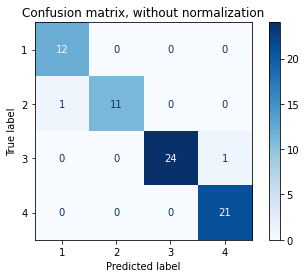

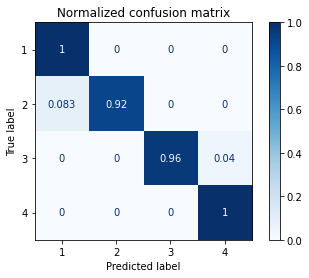

In [31]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(rs_svc, X_test_std, y_test,
                                                 display_labels=[str(x) for x in range(1, 5)],
                                                 cmap=plt.cm.Blues,
                                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

In [32]:
target_names = [str(x) for x in range(1, 5)]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.92      0.96        12
           3       1.00      0.96      0.98        25
           4       0.95      1.00      0.98        21

    accuracy                           0.97        70
   macro avg       0.97      0.97      0.97        70
weighted avg       0.97      0.97      0.97        70



### Kaggle submission

In [33]:
test = pd.read_csv(r'data\test.csv') # nan values in test?? impute?
test = test.drop('index', axis=1)

<Figure size 1152x648 with 0 Axes>

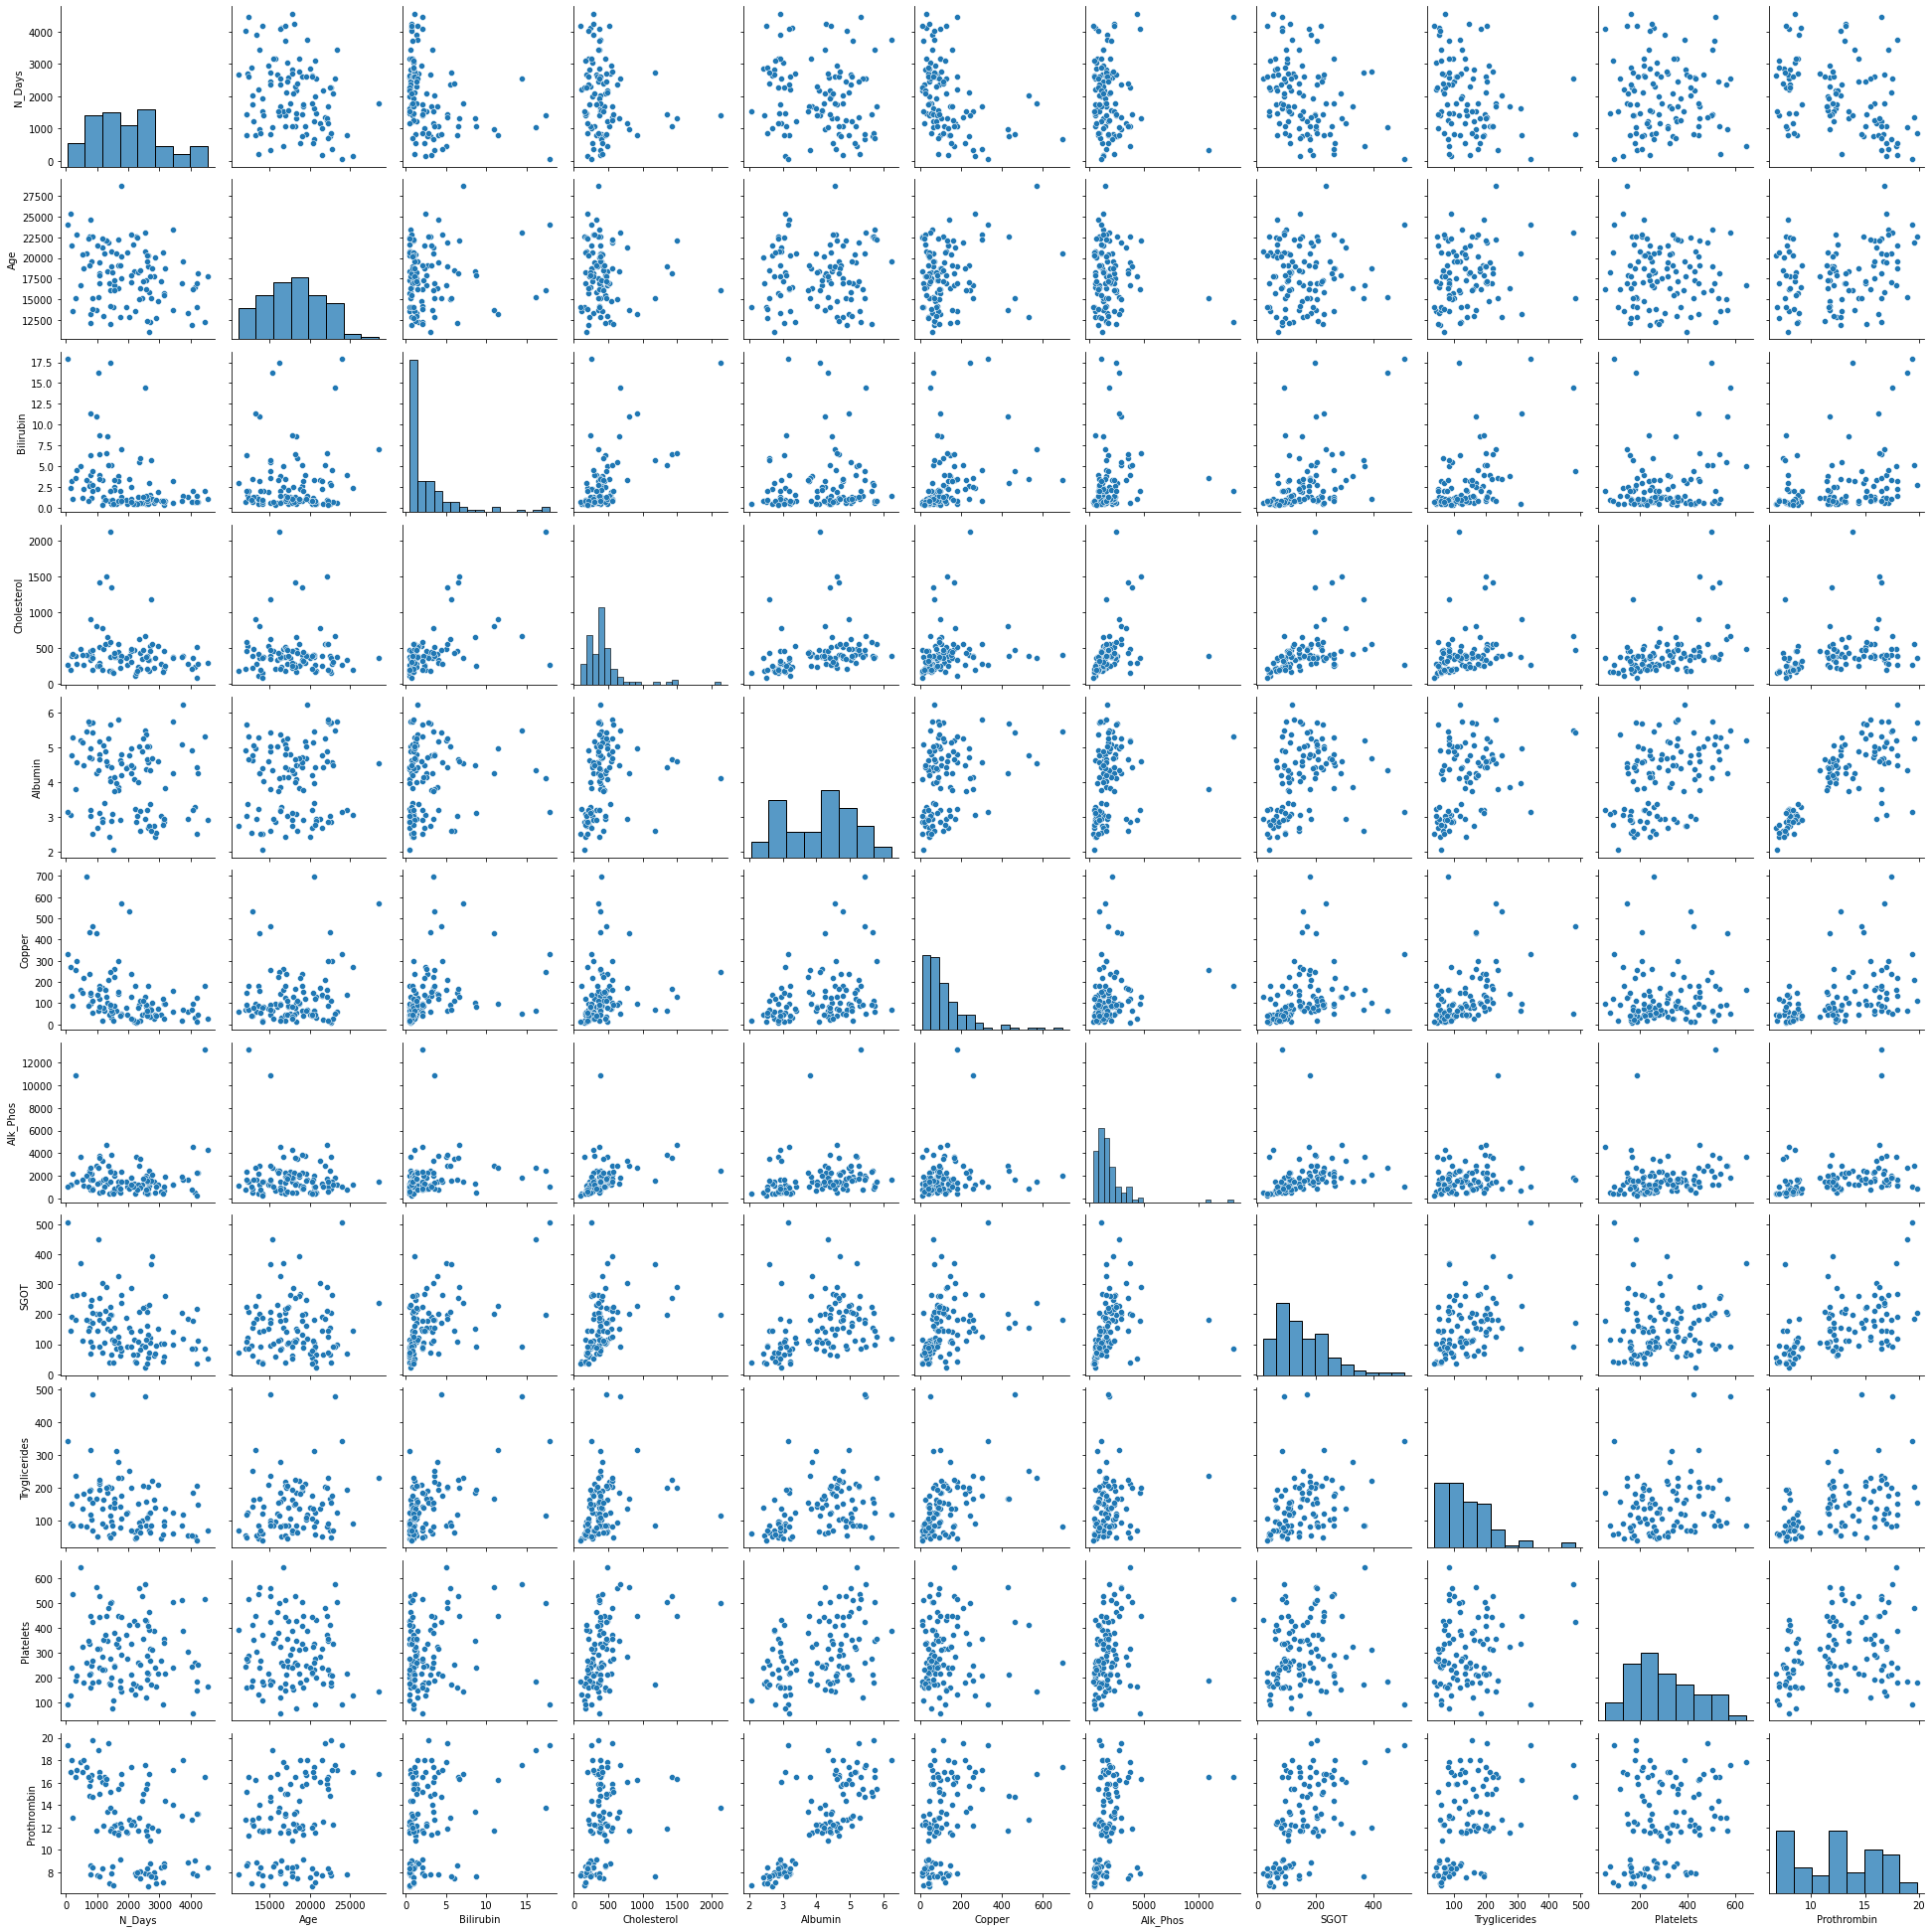

In [34]:

# plt.figure(figsize=(16,9))
# sns.pairplot(data=test)
# plt.show()


In [35]:
# na_test = test.isna().sum()
# nan_columns_test = pd.DataFrame(na_test[na_test != 0]).T.columns.tolist()
# imr_test = SimpleImputer(missing_values=np.nan, strategy='mean')
# imr_test = imr_test.fit(test[nan_columns_test].values)
# imputed_test_values = imr_test.transform(test[nan_columns_test].values)
# imputed_test = test.copy()
# imputed_test[nan_columns_test] = imputed_test_values

In [36]:
dummy_test = pd.get_dummies(imputed_test, drop_first=True)

In [37]:
predictions = gs_svc.predict(dummy_test)
my_submission = pd.DataFrame({'index': list(range(len(predictions))),
                              'Stage': predictions})
my_submission.value_counts()

c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


index  Stage
0      1        1
69     1        1
80     1        1
79     1        1
78     1        1
               ..
33     1        1
32     2        1
31     1        1
30     1        1
108    1        1
Length: 109, dtype: int64

In [38]:
my_submission.to_csv('Submission2.csv', index=False)

#### ROC Curve for binary classificaion problem